In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import Imputer
from sklearn.decomposition import PCA
from sklearn import linear_model, decomposition, datasets
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
%matplotlib inline

In [111]:
df = pd.read_csv('airline_2008.csv')

In [112]:
columns = ['CancellationCode', 'Diverted', 'TailNum','Year','ArrDelay','DepDelay','FlightNum']
df = df.drop(columns, axis=1)

In [113]:
#Dealing with NA values.
#Removing rows that contain less than 15 features
df = df.dropna(thresh=15)

In [114]:
# Fill null values with 0
df = df.fillna(0)
null_count = df.isnull().sum()
null_count[null_count>0]

Series([], dtype: int64)

In [115]:
df['ArrDelay30'] = np.where((df['ArrTime'] - df['CRSArrTime'])>30, 1,0)
df['DepDelay30'] = np.where((df['DepTime'] - df['CRSDepTime'])>30, 1,0)

In [116]:
#Sorting actual departure times into blocks
def DepBlk(time):
    if time > 2259:
        return '2300-2359'
    elif time > 2159:
        return '2200-2259'
    elif time > 2059:
        return '2100-2159'
    elif time > 1959:
        return '2000-2059'
    elif time > 1859:
        return '1900-1959'
    elif time > 1759:
        return '1800-1859'
    elif time > 1659:
        return '1700-1759'    
    elif time > 1559:
        return '1600-1659'
    elif time > 1459:
        return '1500-1559'  
    elif time > 1259:
        return '1300-1359'   
    elif time > 1159:
        return '1200-1259'
    elif time > 1059:
        return '1100-1159'
    elif time > 959:
        return '1000-1059'
    elif time > 859:
        return '0900-0959'  
    elif time > 759:
        return '0800-0859'
    elif time > 659:
        return '0700-0759'
    elif time > 559:
        return '0600-0659'
    elif time > 1:
        return '0001-0559'   

In [117]:
#Sorting actual arrival times into blocks
def ArrBlk(time):
    if time > 2259:
        return '2300-2359'
    elif time > 2159:
        return '2200-2259'
    elif time > 2059:
        return '2100-2159'
    elif time > 1959:
        return '2000-2059'
    elif time > 1859:
        return '1900-1959'
    elif time > 1759:
        return '1800-1859'
    elif time > 1659:
        return '1700-1759'    
    elif time > 1559:
        return '1600-1659'
    elif time > 1459:
        return '1500-1559'  
    elif time > 1259:
        return '1300-1359'   
    elif time > 1159:
        return '1200-1259'
    elif time > 1059:
        return '1100-1159'
    elif time > 959:
        return '1000-1059'
    elif time > 859:
        return '0900-0959'  
    elif time > 759:
        return '0800-0859'
    elif time > 659:
        return '0700-0759'
    elif time > 559:
        return '0600-0659'
    elif time > 1:
        return '0001-0559'   

In [118]:
#Sorting travel distances into blocks
def Dist(miles):
    if miles > 2000:
        return '>2000'
    elif miles > 1500:
        return '1500-2000'
    elif miles > 1000:
        return '1000-1500'
    elif miles > 500:
        return '0500-1000'
    elif miles > 0:
        return '0-500'

In [119]:
df['DepTimeBlk'] = df['DepTime'].apply(DepBlk)
df['ArrTimeBlk'] = df['ArrTime'].apply(ArrBlk)
df['DistBlk'] = df['Distance'].apply(Dist)

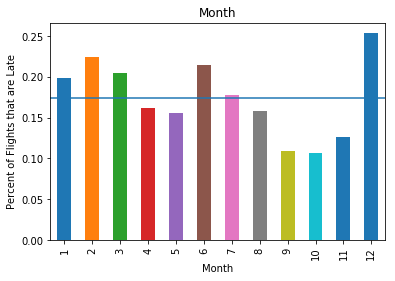

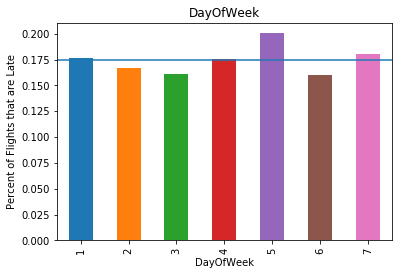

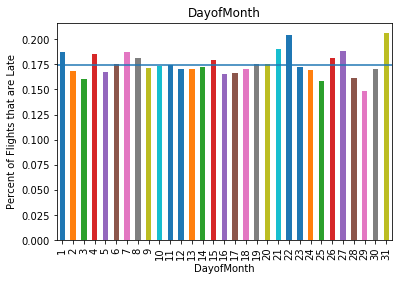

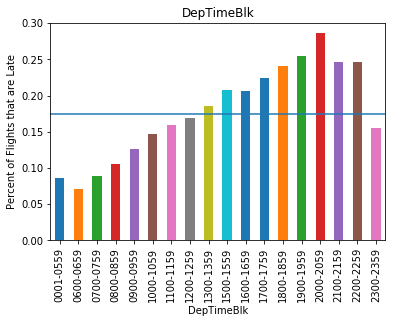

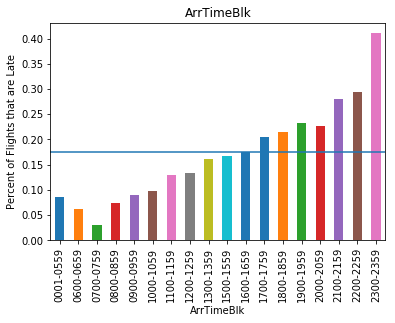

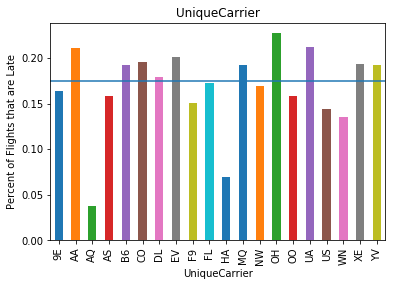

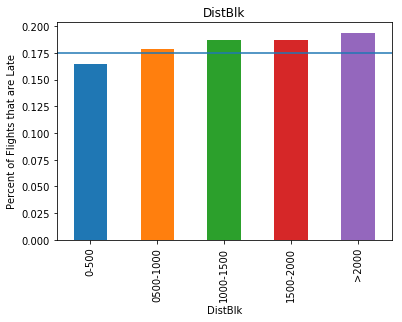

In [95]:
# Proportion of late flights per category based on all other flights

avgLate = np.sum(df['ArrDelay30'])/len(df['ArrDelay30'])
attributes = ['Month','DayOfWeek', 'DayofMonth', 'DepTimeBlk','ArrTimeBlk','UniqueCarrier','DistBlk']
for i, pred in enumerate(attributes):
    plt.figure(i, figsize=(15, 5))
    group = df.groupby([pred], as_index=False).aggregate(np.mean)[[pred, 'ArrDelay30']]
    group.sort_values(by=pred, inplace=True)    
    group.plot.bar(x=pred, y='ArrDelay30')
    plt.axhline(y=avgLate, label='Average')
    plt.ylabel('Percent of Flights that are Late')
    plt.title(pred)
    plt.legend().remove()

In [123]:
#See more delays over winter period (Dec/Jan/Feb). Lower delays in autumn months.
#Not much of a pattern in terms of delays during the week though Fridays tend to show the highest number of delays.
#For departures, flights are often delayed between 1700-2259, mostly around 2200-2059.
#For arrivals, flights are often delayed towards midnight 2300-2359.
#OH (Comair), UA (United Airlines) and AA (American Airlines) have the highest % of flight delays.
#Flights that travel further distances tend to have more late arrivals.

In [135]:
#Late or Cancelled
df['LateorCancelled'] = df['Cancelled'] + df['ArrDelay30']

def late_or_cancelled(x):
    if x == 1:
        return 1
    elif x == 2:
        return 1
    else:
        return 0

In [136]:
df['Late_or_Cancelled'] = df['LateorCancelled'].apply(late_or_cancelled)

In [137]:
#Converting these delays to categorical data. 1 for Delay, 0 for no delays.
df['CarrierDelay'] = np.where((df['CarrierDelay']>1), 1,0)
df['WeatherDelay'] = np.where((df['WeatherDelay']>1), 1,0)
df['NASDelay'] = np.where((df['NASDelay']>1), 1,0)
df['SecurityDelay'] = np.where((df['SecurityDelay']>1), 1,0)
df['LateAircraftDelay'] = np.where((df['LateAircraftDelay']>1), 1,0)

In [138]:
df["Dest"] = df["Dest"].astype('category')
df["Dest_Code"] = df["Dest"].cat.codes
df["Origin"] = df["Origin"].astype('category')
df["Origin_Code"] = df["Origin"].cat.codes
df["UniqueCarrier"] = df["UniqueCarrier"].astype('category')
df["UniqueCarrier_Code"] = df["UniqueCarrier"].cat.codes

In [139]:
columns2 = ['UniqueCarrier', 'Dest', 'Origin','TaxiIn','TaxiOut','AirTime','Cancelled']
df = df.drop(columns2, axis=1)

In [140]:
print(df.head())

   Month  DayofMonth  DayOfWeek  DepTime  CRSDepTime  ArrTime  CRSArrTime  \
0      1           3          4   2003.0        1955   2211.0        2225   
1      1           3          4    754.0         735   1002.0        1000   
2      1           3          4    628.0         620    804.0         750   
3      1           3          4    926.0         930   1054.0        1100   
4      1           3          4   1829.0        1755   1959.0        1925   

   ActualElapsedTime  CRSElapsedTime  Distance        ...          ArrDelay30  \
0              128.0           150.0       810        ...                   0   
1              128.0           145.0       810        ...                   0   
2               96.0            90.0       515        ...                   1   
3               88.0            90.0       515        ...                   0   
4               90.0            90.0       515        ...                   1   

   DepDelay30  DepTimeBlk  ArrTimeBlk    DistBlk  

In [141]:
X = df[['Month','DayofMonth','DayOfWeek','DepTime','CRSDepTime','ArrTime','CRSArrTime',
       'UniqueCarrier_Code','Dest_Code','Origin_Code','CarrierDelay','WeatherDelay',
       'NASDelay','SecurityDelay','LateAircraftDelay']]
Y = df['Late_or_Cancelled']

In [146]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)

In [150]:
#Random Forest Search
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(max_depth=10, max_features='sqrt',
                                   max_leaf_nodes=None, min_samples_leaf=2,
                                   min_samples_split=2,
                                   n_estimators=5,
                                   n_jobs=-1, warm_start=False)
forest_reg.fit(X_train,Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [151]:
#Confusion Matrix for train set.
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_train,(forest_reg.predict(X_train)).round())

array([[3737024,  225713],
       [ 132717,  705201]])

In [158]:
#Confusion Matrix for test set.
confusion_matrix(Y_test,(forest_reg.predict(X_test)).round())

array([[1601125,   96702],
       [  56720,  302877]])

In [162]:
from sklearn.model_selection import cross_val_score
from sklearn import cross_validation
startTimeRF = datetime.now()
cv = cross_validation.KFold(len(X_train), n_folds=3, shuffle=True, random_state=2)
cvScores = cross_val_score(forest_reg, X_train, Y_train, cv=cv)
print ('Mean cross validation score is: ' + str(np.mean(cvScores)))
forest_reg.fit(X_train, Y_train)
print('Random forest training and testing with PCs took [', datetime.now() - startTimeRF, '] seconds.')

Mean cross validation score is: 0.632174506553
Random forest training and testing with PCs took [ 0:02:23.656223 ] seconds.
